# Similarity of activity sequences

Copyright 2023 Maria Lima  
(mr3418@ic.ac.uk)

Last updated: 10/06/2023

### Dependencies

In [1]:
import pickle
import numpy as np
import pandas as pd
import pylab as plt
import ipynb
import gzip
from utils import similarity as sim
from utils import cluster_sequences as clu
from utils import behav_events as beh

### Load and process data

In [2]:
PATH = './datasets/'
with gzip.open(PATH +'df_activity.pkl.gz', 'rb') as f: # compressed file
    df_act = pickle.load(f)
df_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2585692 entries, 0 to 2585691
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   start_date  datetime64[ns]
 1   patient_id  object        
 2   event       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 59.2+ MB


### EDA similarity matrix

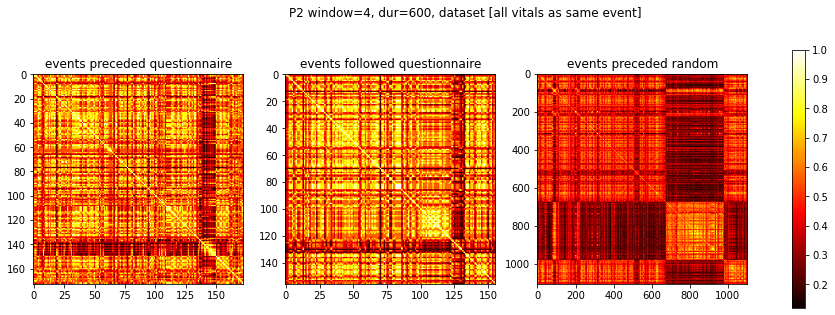

In [5]:
sim.plot_similarity_types(user='P2', win=4, dur=600, data=df_act)

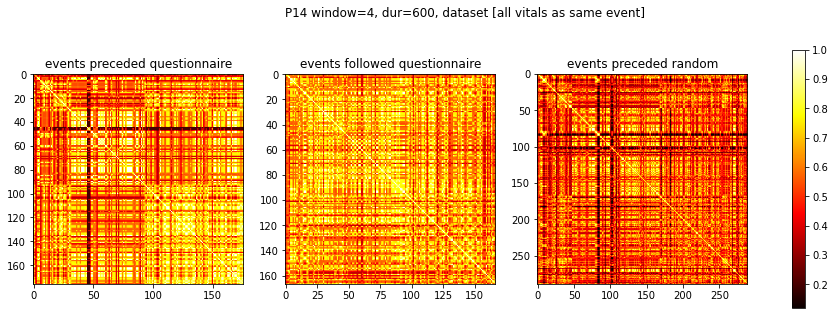

In [6]:
sim.plot_similarity_types(user='P14', win=4, dur=600, data=df_act)

##### Grid of similarity matrices per interaction type per relevant users (win=4, dur=600)

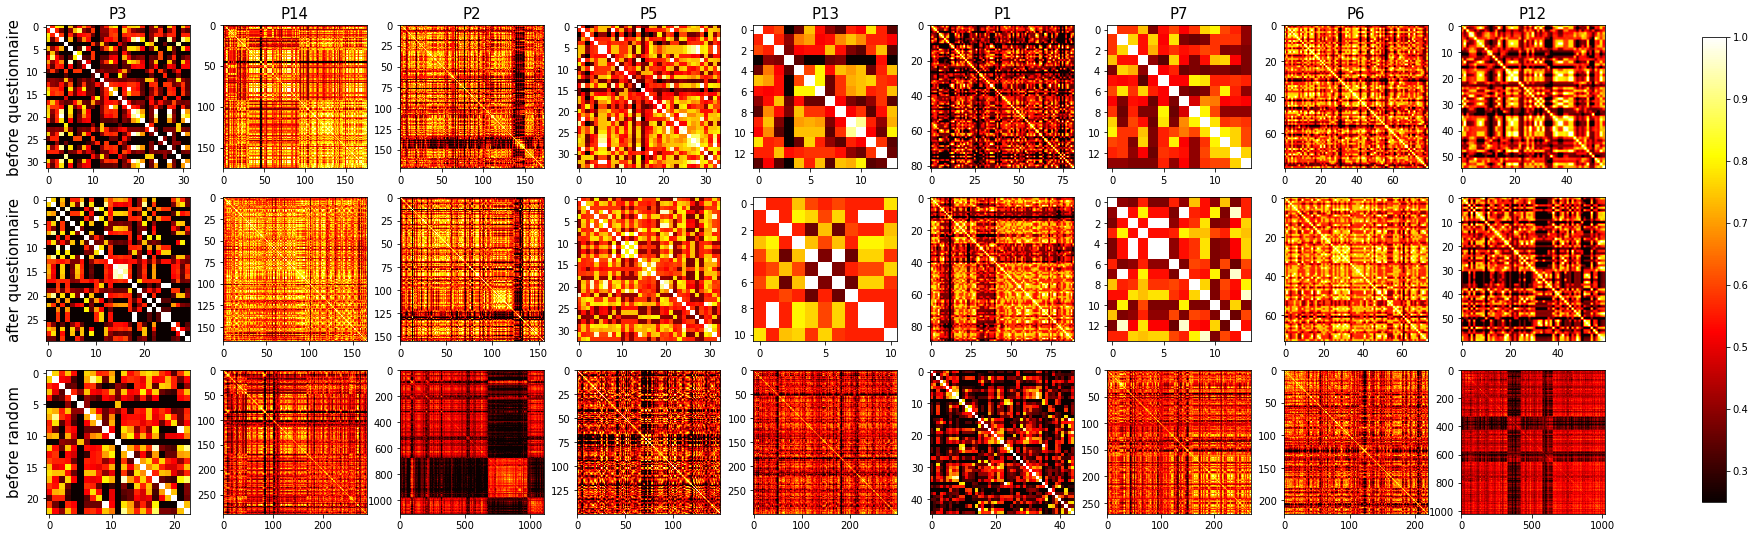

In [8]:
# selected users
rich_users = [x for x in df_act.patient_id.unique() if x not in ['P4', 'P8', 'P9', 'P10', 'P11']]
fig,ax = plt.subplots(3,9,figsize=(35,9))
for i,pid in enumerate(rich_users):
    ds_start , df_start = sim.get_sim(df_act, pid, window = 4, source = False, target = 's_start') #sink
    ds_end, df_end = sim.get_sim(df_act, pid, window = 4, source=True, target='s_end') #source
    ds_r, df_r = sim.get_sim(df_act, pid, window = 4, source=False, target='r') #sink
    u = ax[0, i].imshow(ds_start,vmin=0.25,vmax=1.0,cmap='hot') # baseline is 25%
    ax[1, i].imshow(ds_end,vmin=0.25,vmax=1.0,cmap='hot') # baseline is 25%
    ax[2, i].imshow(ds_r,vmin=0.25,vmax=1.0,cmap='hot') # baseline is 25%
cols = ['{}'.format(col) for col in rich_users]
rows = ['{}'.format(row) for row in ['before questionnaire', 'after questionnaire', 'before random']]
# column title
for axes, col in zip(ax[0], cols):
    axes.set_title(col, fontsize=15)
# row title
for axes, row in zip(ax[:,0], rows):
    axes.set_ylabel(row, fontsize=15)
cbar = fig.colorbar(u, ax=ax.ravel().tolist(), shrink=0.95)
plt.show()

### Probability of activity before/after Alexa triggers

In [3]:
for user in ['P2', 'P6', 'P12', 'P14']:
    print(f'Loading {user}...')
    ds_1, ds_2, ds_3, df_1, df_2, df_3 = sim.get_sim_df(pid=user, data=df_act)
    events = list(df_act.event.unique())
    globals()[f'prob_events_{user}'] = pd.DataFrame(columns=['A','B','C'])
    globals()[f'probs{user}'] = clu.contingency_prob(df_1, random=False)
    globals()[f'probs{user}']['B'] = beh.get_array_percent(df_2, events, random=False)
    globals()[f'probs{user}']['C'] = beh.get_array_percent(df_3, events)
    globals()[f'prob_events_{user}'] = globals()[f'probs{user}']
    print(f'{user} processed')

Loading P2...
P2 processed
Loading P6...
P6 processed
Loading P12...
P12 processed
Loading P14...
P14 processed


In [4]:
# copy datasets
prob_test_p2 = prob_events_P2.copy()
prob_test_p6 = prob_events_P6.copy()
prob_test_p12 = prob_events_P12.copy()
prob_test_p14 = prob_events_P14.copy()
# For A, B, C target events...
columns=[
    ('P2','A(%)'),('P2','B(%)'), ('P2','C(%)'),
    ('P6','A(%)'),('P6','B(%)'), ('P6','C(%)'), 
    ('P12','A(%)'),('P12','B(%)'), ('P12','C(%)'), 
    ('P14','A(%)'),('P14','B(%)'), ('P14','C(%)')
    ]
# prob_all_users = pd.concat([prob_test_u11, prob_test_u22, prob_test_u23, prob_test_u24], axis=1)
prob_all_users = pd.concat([prob_test_p2, prob_test_p6, prob_test_p12, prob_test_p14], axis=1)
prob_all_users.columns=pd.MultiIndex.from_tuples(columns)
prob_all_users = prob_all_users.apply(pd.to_numeric, errors='coerce', downcast=None)
prob_all_users = prob_all_users.rename(index={'Bed_in':'Bed in', 'Bed_out':'Bed out', 'vitals':'Vitals', 'r':'Random', 's_start':'Start', 's_end':'End'})
a = prob_all_users.style.background_gradient(cmap='Blues').format(precision=2)
a

## Cluster activity sequences (method)

- Given a similarity metric (Ordering-based Sequence Similarity), we calculate pairwise similarity of activity sequences and form similarity matrices. 
- We now want to cluster the activity sequences (i.e., the data points) into partitions. 
- Apply K-Medoids (PAM) algorithm with the precomputed distance/similarity metric 

### P2: Paper see Fig 7(a) 
s_n = Random (activity sequences preceding topics/random Alexa trigger)

In [5]:
ds_1_p2, ds_2_p2, ds_3_p2, df_1_p2, df_2_p2, df_3_p2 = sim.get_sim_df(pid='P2', win=4, dur=600, data=df_act)
ds_1_p2 = df_1_p2.loc[:,0:]
ds_1_p2 = 1 - ds_1_p2 # distance
ds_3_p2 = df_3_p2.loc[:,0:]
ds_3_p2 = 1 - ds_3_p2 # distance

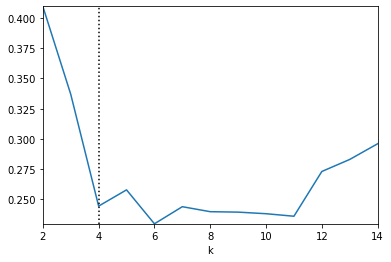

In [8]:
# random_state = 5
clu.check_silhouette(clu.find_n_clusters(ds_3_p2, random_state=5))

K clusters used:    k  silhouette
2  4    0.244314
Check: 4


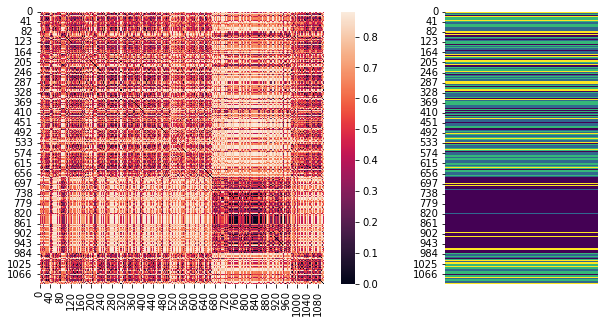

In [9]:
sc_p2_3 = clu.apply_clustering(ds_3_p2, random_state=5)
clu.plot_clusters(ds_3_p2, sc_p2_3)

In [11]:
clustered_ = clu.index_clusters(df_3_p2, sc_p2_3)
for i in clustered_.cluster.unique():
    cluster_x = clustered_[clustered_.cluster == i].index.to_numpy()
    globals()[f'seq_df1_{i}'] = df_3_p2[df_3_p2.index.isin(cluster_x)]

# table with behavioural events and probability of occurrence within clusters
probs = clu.contingency_prob(seq_df1_0, random = False)
probs['cluster_1'] = clu.get_array_percent(seq_df1_1, random = False)
probs['cluster_2'] = clu.get_array_percent(seq_df1_2, random = False)
probs['cluster_3'] = clu.get_array_percent(seq_df1_3, random = False)
probs

,cluster_0,cluster_1,cluster_2,cluster_3
Bed_in,0.0,0.16,0.0,0.00
Bed_out,0.0,0.00,0.1,0.00
vitals,1.82,4.30,1.5,0.46
Bathroom,14.0,2.19,0.2,1.61
Bedroom,25.75,1.54,0.1,2.06
Hallway,12.84,2.35,0.6,1.15
Lounge,1.02,21.10,41.5,12.61
Kitchen,0.44,36.28,13.3,4.36
Back door,0.0,3.73,1.4,0.00
Front door,0.07,0.57,0.6,0.00


In [12]:
# separate each cluster
# how many activity sequences (data points) considered in each one
cluster_x = clustered_[clustered_.cluster == 0]
cluster_y = clustered_[clustered_.cluster == 1]
cluster_z = clustered_[clustered_.cluster == 2]
cluster_w = clustered_[clustered_.cluster == 3]
print(len(cluster_x), len(cluster_y), len(cluster_z), len(cluster_w))
print(np.sum([len(cluster_x), len(cluster_y), len(cluster_z), len(cluster_w)]))

364 313 271 156
1104


In [13]:
# check time slots within this interval
timeslot_p2 = df_3_p2.loc[660:980, ['start_date', 'end_date', 'transition']]
hours = [-1, 12, 17, 24]
slots = ['morning', 'afternoon', 'evening']
timeslot_p2 = timeslot_p2.assign(
    time_slot= pd.cut(timeslot_p2.start_date.dt.hour,hours,labels=slots)
    )
timeslot_p2.time_slot.value_counts()

morning      200
afternoon    102
evening       19
Name: time_slot, dtype: int64

In [16]:
# start and end date of time period
print(timeslot_p2.end_date.min())
print(timeslot_p2.end_date.max())
# number of weeks
print(timeslot_p2.end_date.dt.week.nunique())

2022-04-03 10:45:00
2022-05-07 12:11:00
6


/var/folders/xx/gc1pd92159b41vdn712h03ym0000gp/T/ipykernel_29710/1135674623.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  print(timeslot_p2.end_date.dt.week.nunique())


In [17]:
c = timeslot_p2[timeslot_p2.time_slot == 'morning']
c.end_date.dt.hour.value_counts()

11    112
12     41
10     33
9       5
8       4
13      4
7       1
Name: end_date, dtype: int64

In [18]:
c = timeslot_p2[timeslot_p2.time_slot == 'evening']
c.end_date.dt.hour.value_counts()

18    18
19     1
Name: end_date, dtype: int64

In [19]:
# excluding 13h (1pm), account only for morning
(200-4)/len(timeslot_p2) *100

61.059190031152646

In [20]:
# excluding 13h (1pm), account only for morning
19/len(timeslot_p2) *100

5.919003115264798

#### Check inside X1
one of these clusters (denoted as cluster X1) was found to be predominant during 6 weeks in April and May 2022 (denoted as period A, see selected border), i.e., within this time period, 84.69% of sequences belonged to the cluster X1, and 74.45% of the sequences in cluster X1 was located in this time period:

In [22]:
check_sequence = clu.index_clusters(df_3_p2, sc_p2_3)
check_sequence[660:980].cluster.value_counts()

0    271
3     29
1     17
2      3
Name: cluster, dtype: int64

In [23]:
within_interval = check_sequence[660:980]
# calculate value counts normalized
cluster_percentages_within = within_interval['cluster'].value_counts(normalize=True)
# multiply by 100 to convert to percentage
cluster_percentages_within *= 100
cluster_percentages_within = cluster_percentages_within.round(2)
cluster_percentages_within

0    84.69
3     9.06
1     5.31
2     0.94
Name: cluster, dtype: float64

In [24]:
print(clu.countInRange(cluster_x, x=660, y=980))
print(clu.countInRange(cluster_y, x=660, y=980))
print(clu.countInRange(cluster_w, x=660, y=980))

74.451% of cluster located in time period 660:980 
74.451
5.431% of cluster located in time period 660:980 
5.431
18.59% of cluster located in time period 660:980 
18.59


#### Check outside X1

In [25]:
# drop rows from index 660 to 980
df_without_interval = check_sequence.drop(check_sequence.index[660:981])
df_without_interval.cluster.value_counts()

1    296
2    267
3    127
0     93
Name: cluster, dtype: int64

In [26]:
# calculate value counts normalized
cluster_percentages = df_without_interval['cluster'].value_counts(normalize=True)

# multiply by 100 to convert to percentage
cluster_percentages *= 100
cluster_percentages = cluster_percentages.round(2)
cluster_percentages

1    37.80
2    34.10
3    16.22
0    11.88
Name: cluster, dtype: float64

Note: the same method can be applied to the remaining similarity matrices presented in the paper Fig. 7.